# Sparkify Project 
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from datetime import datetime

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [4]:
df.createOrReplaceTempView('sparkify_data')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
#number of lines
df.count()

286500

In [7]:
#checking columns properties
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's count the number of times each user appears:

In [11]:
spark.sql("""select userId, count(userId) as count
             from sparkify_data
             group by userId
             order by count desc""").show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
+------+-----+
only showing top 20 rows



There seems to exist a user with no id, I'll investigate this later.

In [12]:
#number of unique users
spark.sql("""select count (distinct userId) from sparkify_data""").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



Now let's check how frequent each page is in the dataset:

In [13]:
spark.sql("""select page, count(page) as count
             from sparkify_data
             group by page
             order by count desc""").toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [6]:
#proportion of paid/free users
df.groupBy('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [10]:
spark.sql("""select level, count(level)
             from sparkify_data
             group by level""").show()

+-----+------------+
|level|count(level)|
+-----+------------+
| free|       58338|
| paid|      228162|
+-----+------------+



In [7]:
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



It seems that users without Id also don't have gender assigned. Let's drop them.

In [8]:
drop_df = df.filter(df.userId != "")
drop_df.count()

278154

In [11]:
drop_df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [9]:
#defining churn as every user who confirmed a cancellation
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0)

df_2 = drop_df.withColumn('churn_flag', churn(df.page))

In [10]:
df_2.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn_flag: string (nullable = true)



In [12]:
df_2.createOrReplaceTempView('sparkify_data_churn')

In [15]:
spark.sql("""select churn_flag, count(churn_flag)
          from sparkify_data_churn
          group by churn_flag""").show()

+----------+-----------------+
|churn_flag|count(churn_flag)|
+----------+-----------------+
|         0|           278102|
|         1|               52|
+----------+-----------------+



In [16]:
spark.sql("""select churn_flag, gender, count(gender)
             from sparkify_data_churn
             group by churn_flag, gender""").show()

+----------+------+-------------+
|churn_flag|gender|count(gender)|
+----------+------+-------------+
|         0|     M|       123544|
|         1|     M|           32|
|         0|     F|       154558|
|         1|     F|           20|
+----------+------+-------------+



In [17]:
spark.sql("""select churn_flag, level, count(level)
             from sparkify_data_churn
             group by churn_flag, level""").show()

+----------+-----+------------+
|churn_flag|level|count(level)|
+----------+-----+------------+
|         0| paid|      222402|
|         1| paid|          31|
|         0| free|       55700|
|         1| free|          21|
+----------+-----+------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

From the observed pages it's possible to make the following features:

- listening time per user
- days since registration
- number of sessions
- number of songs per user
- number of thumbs up 
- number of thumbs down
- number of added friends

### Calculating listening time

In [13]:
listening_time = spark.sql("""select userId, sum(length) as listening_time  
                              from sparkify_data_churn
                              where page = 'NextSong'
                              group by userId""")

listening_time.show()

+------+------------------+
|userId|    listening_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



### Calculating number of thumbs up

In [14]:
thumbs_up = spark.sql("""select userId, count(page) as thumbs_up  
                         from sparkify_data_churn
                         where page = 'Thumbs Up'
                         group by userId""")

thumbs_up.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
|    15|       81|
|   155|       58|
|   132|       96|
|   154|       11|
|100014|       17|
|   101|       86|
|    11|       40|
|   138|       95|
|300017|      303|
|    29|      154|
|    69|       72|
|100021|       11|
|    42|      166|
|   112|        9|
+------+---------+
only showing top 20 rows



### Calculating number of thumbs down

In [15]:
thumbs_down = spark.sql("""select userId, count(page) as thumbs_down 
                           from sparkify_data_churn
                           where page = 'Thumbs Down'
                           group by userId""")

thumbs_down.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
|    15|         14|
|    54|         29|
|   155|          3|
|   132|         17|
|100014|          3|
|   101|         16|
|    11|          9|
|   138|         24|
|300017|         28|
|    29|         22|
|    69|          9|
|100021|          5|
|    42|         25|
|   112|          3|
|    73|          7|
+------+-----------+
only showing top 20 rows



### Calculating number of friends

In [16]:
friends = spark.sql("""select userId, count(page) as friends  
                       from sparkify_data_churn
                       where page = 'Add Friend'
                       group by userId""")
friends.show()

+------+-------+
|userId|friends|
+------+-------+
|100010|      4|
|200002|      4|
|    51|     28|
|   124|     74|
|     7|      1|
|    54|     33|
|    15|     31|
|   155|     11|
|   132|     41|
|   154|      3|
|100014|      6|
|   101|     29|
|    11|      6|
|   138|     41|
|300017|     63|
|    29|     47|
|    69|     12|
|100021|      7|
|    42|     52|
|   112|      7|
+------+-------+
only showing top 20 rows



### Calculating number of sessions per user

In [17]:
sessions = spark.sql("""select userId, count(distinct sessionId) as sessions  
                        from sparkify_data_churn
                        group by userId""")
sessions.show()

+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
|   125|       1|
|    51|      10|
|   124|      29|
|     7|       7|
|    54|      37|
|    15|      15|
|   155|       6|
|100014|       6|
|   132|      16|
|   154|       3|
|   101|      10|
|    11|      16|
|300017|      63|
|   138|      15|
|    29|      34|
|    69|       9|
|100021|       5|
|    42|      47|
+------+--------+
only showing top 20 rows



### Calculating number of listened songs per user

In [18]:
songs = spark.sql("""select userId, count(Song) as total_songs  
                     from sparkify_data_churn
                     group by userId""")

songs.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        275|
|200002|        387|
|   125|          8|
|    51|       2111|
|   124|       4079|
|     7|        150|
|    54|       2841|
|    15|       1914|
|   155|        820|
|   132|       1928|
|   154|         84|
|100014|        257|
|   101|       1797|
|    11|        647|
|   138|       2070|
|300017|       3632|
|    29|       3028|
|    69|       1125|
|100021|        230|
|    42|       3573|
+------+-----------+
only showing top 20 rows



### Calculating number of active days for each user 

In [19]:
active = spark.sql("""select userId, min(registration) as created, max(ts) as last_session 
                   from sparkify_data_churn
                   group by userId""")

In [20]:
def compute_active_days(created, last_session):
    """Calculates the difference between an account date of registration and
        its most recent login date.
        
        Parameters:
        -----------
        created
            date of creation timestamp : str
        last_session
            last login date : str
            
        Returns:
        --------
        active_days : int
            number of active days
        """
    
    created = int(created)/1000
    last_session = int(last_session)/1000
    
    active_days = (datetime.fromtimestamp(last_session) - datetime.fromtimestamp(created)).days
    return active_days

active_days = udf(compute_active_days, IntegerType())
active = active.withColumn("active_days", active_days(active.created, active.last_session))

In [21]:
active.show()

+------+-------------+-------------+-----------+
|userId|      created| last_session|active_days|
+------+-------------+-------------+-----------+
|100010|1538016340000|1542823952000|         55|
|200002|1536269906000|1542324354000|         70|
|   125|1533157139000|1539318918000|         71|
|    51|1538080987000|1539761972000|         19|
|   124|1532224335000|1543590766000|        131|
|     7|1536667576000|1542955611000|         72|
|    54|1532482662000|1542051608000|        110|
|    15|1538239045000|1543121818000|         56|
|   155|1541370470000|1543405710000|         23|
|   132|1537054553000|1542833772000|         66|
|   154|1541268021000|1543330565000|         23|
|100014|1535389443000|1542740649000|         85|
|   101|1535066380000|1539729037000|         53|
|    11|1532554781000|1543309702000|        124|
|   138|1537865819000|1543622365000|         66|
|300017|1537082511000|1543507087000|         74|
|    29|1536988041000|1542181031000|         60|
|    69|153682415900

### Churn flag

In [22]:
churn = spark.sql("""select userId, max(churn_flag) as churn
                     from sparkify_data_churn
                     group by UserId""")
churn.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [23]:
user_data = listening_time.join(thumbs_up, on='userId', how='outer')\
                         .join(thumbs_down, on='userId', how='outer')\
                         .join(songs, on='userId', how='outer')\
                         .join(sessions, on='userId', how='outer')\
                         .join(friends, on='userId', how='outer')\
                         .join(active, on='userId', how='outer')\
                         .join(churn, on='userId', how='outer')

In [24]:
user_data.toPandas().head(20)

,userId,listening_time,thumbs_up,thumbs_down,total_songs,sessions,friends,created,last_session,active_days,churn
0,100010,6.694090e+04,17.0,5.0,275,7,4.0,1538016340000,1542823952000,55,0
1,200002,9.400888e+04,21.0,6.0,387,6,4.0,1536269906000,1542324354000,70,0
2,125,2.089113e+03,NaN,NaN,8,1,NaN,1533157139000,1539318918000,71,1
3,124,1.012312e+06,171.0,41.0,4079,29,74.0,1532224335000,1543590766000,131,0
4,51,5.232758e+05,100.0,21.0,2111,10,28.0,1538080987000,1539761972000,19,1
5,7,3.803409e+04,7.0,1.0,150,7,1.0,1536667576000,1542955611000,72,0
6,15,4.773076e+05,81.0,14.0,1914,15,31.0,1538239045000,1543121818000,56,0
7,54,7.113449e+05,163.0,29.0,2841,37,33.0,1532482662000,1542051608000,110,1
8,155,1.987793e+05,58.0,3.0,820,6,11.0,1541370470000,1543405710000,23,0
9,100014,6.770347e+04,17.0,3.0,257,6,6.0,1535389443000,1542740649000,85,1


As we can see above, there is still some work to be done:
- I'll input NaNs with 0, as it makes sense that some users don't have friends or never used the thumbs up/down feature of the app.
- Columns `created` and `last_session` can be dropped.

In [25]:
full_df = user_data.drop('created').drop('last_session').fillna(0)

In [26]:
full_df.toPandas().head()

,userId,listening_time,thumbs_up,thumbs_down,total_songs,sessions,friends,active_days,churn
0,100010,6.694090e+04,17,5,275,7,4,55,0
1,200002,9.400888e+04,21,6,387,6,4,70,0
2,125,2.089113e+03,0,0,8,1,0,71,1
3,124,1.012312e+06,171,41,4079,29,74,131,0
4,51,5.232758e+05,100,21,2111,10,28,19,1


In [27]:
full_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- listening_time: double (nullable = false)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- total_songs: long (nullable = true)
 |-- sessions: long (nullable = true)
 |-- friends: long (nullable = true)
 |-- active_days: integer (nullable = true)
 |-- churn: string (nullable = true)



In [28]:
#transforming features to vectors

feature_cols = ['listening_time', 'thumbs_up', 'thumbs_down', 'total_songs',
                'sessions', 'friends', 'active_days']

assembler = VectorAssembler(
    inputCols = feature_cols,
    outputCol = 'features')

model_df = assembler.transform(full_df)

#renaming churn column to 'label'
model_df = model_df.withColumn("label", model_df['churn'].cast(IntegerType()))

In [29]:
#scaling
scaler = StandardScaler(inputCol = 'features', outputCol='scaled_features')
model_df = scaler.fit(model_df).transform(model_df)

In [30]:
#checking if everything is correct
model_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- listening_time: double (nullable = false)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- total_songs: long (nullable = true)
 |-- sessions: long (nullable = true)
 |-- friends: long (nullable = true)
 |-- active_days: integer (nullable = true)
 |-- churn: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- scaled_features: vector (nullable = true)



# Modeling
Split the full dataset into train and test sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [31]:
train, test = model_df.randomSplit([0.8, 0.2], seed = 42)

rf = RandomForestClassifier(labelCol='label', 
                            featuresCol='scaled_features',
                            numTrees=10)

rf_model = rf.fit(train)
preds = rf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

score = evaluator.evaluate(preds)
print('Random Forest - F1:', score)

Random Forest - F1: 0.8141923436041085


In [39]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier

lr = LogisticRegression(featuresCol='scaled_features', maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)
lr_model = lr.fit(train)

preds = lr_model.transform(test)
score = evaluator.evaluate(preds)
print('Logistic Regression - F1:', score)

Logistic Regression - F1: 0.6627450980392157


In [40]:
gbt = GBTClassifier(featuresCol='scaled_features',
                    labelCol='label',
                    maxIter=10)
gbt_model = gbt.fit(train)
preds = gbt_model.transform(test)

score = evaluator.evaluate(preds)
print('GBT - F1:', score)

GBT - F1: 0.7058823529411765


## Hyperparameter Tuning

In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
            .addGrid(rf_model.numTrees, [50, 100, 200]) \
            .addGrid(rf_model.impurity, ['gini', 'entropy']) \
            .build()

cross_val = CrossValidator(estimator=rf,
                           estimatorParamMaps=param_grid,
                           evaluator=MulticlassClassificationEvaluator(),
                           numFolds=3)

cv_model = cross_val.fit(train)

In [33]:
cv_preds = cv_model.transform(test)

score = evaluator.evaluate(cv_preds)
print('Hyperparameter model - F1:', score)

Hyperparameter model - F1: 0.8399835458658989


In [34]:
cv_model.avgMetrics

[0.750604103763751,
 0.7471231872910409,
 0.76037264007762,
 0.7708354914427111,
 0.7686046233235793,
 0.7842250417998409]

In [41]:
cv_model.bestModel.getNumTrees

200

In [51]:
cv_model.bestModel.featureImportances

SparseVector(7, {0: 0.127, 1: 0.0827, 2: 0.1567, 3: 0.0628, 4: 0.0901, 5: 0.1271, 6: 0.3537})

## Feature importances

In [52]:
importances = dict(zip(feature_cols, cv_model.bestModel.featureImportances))

In [53]:
ordered_importances = dict(sorted(importances.items(), key=lambda item: item[1]))

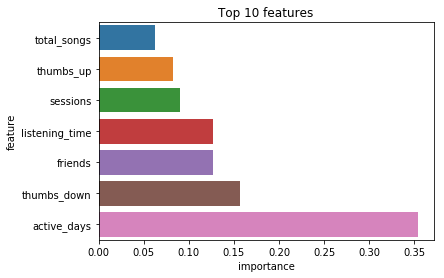

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.barplot(y=list(ordered_importances.keys()), x=list(ordered_importances.values()))
plt.title('Top 10 features')
plt.ylabel('feature')
plt.xlabel('importance');